In [1]:
import import_ipynb
import matplotlib.pyplot as plt

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt

from DAFNO_utilities import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import os
import sys
from itertools import chain



class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer for eDAFNO:
        Computes the integral operator I(o; v^l) using FFT-based convolutions.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        # Pointwise multiplication in Fourier space
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, h, chi):
        """
        Args:
            h: Input tensor (batch_size, in_channels, height, width).
            chi: Domain encoding (batch_size, 1, height, width).

        Returns:
            Output tensor after applying I(chi * h; v^l) - h * I(chi; v^l).
        """
        batchsize, _, height, width = h.shape

        # Fourier transform of h and chi
        h_ft = torch.fft.rfft2(h, s=(height, width)).to(torch.cfloat)  # Ensure complex float
        chi_ft = torch.fft.rfft2(chi, s=(height, width)).to(torch.cfloat)  # Ensure complex float

        # Slice Fourier modes to match the learnable kernel size
        h_ft = h_ft[:, :, :self.modes1, :self.modes2]
        chi_ft = chi_ft[:, :, :self.modes1, :self.modes2]

        # Fourier transform of the learnable kernel
        kernel_ft = self.weights

        # Compute I(chi * h; v^l)
        integral_chi_h = torch.fft.irfft2(self.compl_mul2d(h_ft, kernel_ft), s=(height, width))

        # Compute I(chi; v^l)
        integral_chi = torch.fft.irfft2(self.compl_mul2d(chi_ft, kernel_ft), s=(height, width))

        # Final result: I(chi * h; v^l) - h * I(chi; v^l)
        output = chi * (integral_chi_h - h * integral_chi)
        return output



def scheduler(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer


def LR_schedule(learning_rate, steps, scheduler_step, scheduler_gamma):
    return learning_rate * np.power(scheduler_gamma, (steps // scheduler_step))


def smooth_chi(mask, dist, smooth_coef):
    return torch.mul(torch.tanh(dist * smooth_coef), (mask - 0.5)) + 0.5

In [3]:
class eDAFNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, nlayers):
        super(eDAFNO2d, self).__init__()

        """
        eDAFNO model with explicit χ(x)χ(y) domain encoding and FFT-based integral operator.
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.inp_size = 3  # (x, y, g(x)) for input function and spatial grid
        self.nlayers = nlayers

        self.fc0 = nn.Linear(self.inp_size, self.width)

        for i in range(self.nlayers):
            self.add_module(
                f"conv{i}",
                SpectralConv2d(self.width, self.width, self.modes1, self.modes2),
            )
            self.add_module(f"w{i}", nn.Conv2d(self.width, self.width, 1))

        self.fc1 = nn.Sequential(
            nn.Linear(self.width, 128),
            nn.GELU(),
            nn.Linear(128, 1),
        )

    def forward(self, g, chi):
        """
        Args:
            g: Input function tensor (batch_size, height, width, 1).
            chi: Domain encoding tensor (batch_size, height, width, 1).

        Returns:
            Output tensor of shape (batch_size, height, width, 1).
        """
        batchsize, height, width, _ = g.shape

        # Create grid and concatenate with inputs
        grid = self.get_grid(batchsize, height, width, g.device)
        inputs = torch.cat([grid, g], dim=-1)
        x = self.fc0(inputs)
        x = x.permute(0, 3, 1, 2)
        chi = chi.permute(0, 3, 1, 2)

        for i in range(self.nlayers):
            conv_x = self._modules[f"conv{i}"](x, chi)
            wx = self._modules[f"w{i}"](x)
            x = conv_x + wx
            if i < self.nlayers - 1:
                x = F.gelu(x)

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        return x

    def get_grid(self, batchsize, size_x, size_y, device):
        gridx = torch.linspace(-0.5, 0.5, size_x, dtype=torch.float, device=device)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat(batchsize, 1, size_y, 1)
        gridy = torch.linspace(-0.5, 0.5, size_y, dtype=torch.float, device=device)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat(batchsize, size_x, 1, 1)
        return torch.cat((gridx, gridy), dim=-1)


In [4]:
from scipy.ndimage import distance_transform_edt


def calculate_positive_distance_to_boundary(mask):
    """
    Given a 2D binary mask, calculate the positive Euclidean distance to the boundary of the shape.
    Boundary entries will have a distance of 0.

    Args:
        mask (np.ndarray): A 2D array of 0s and 1s defining the shape.

    Returns:
        np.ndarray: An array of the same shape where each entry is the positive Euclidean distance to the boundary.
    """
    # Ensure the mask is binary
    mask = mask.astype(bool)

    # Calculate distances inside and outside the shape
    distance_inside = distance_transform_edt(mask)
    distance_outside = distance_transform_edt(~mask)

    # Boundary pixels will have 0 distance
    distance_to_boundary = np.maximum(distance_inside, distance_outside)

    return distance_to_boundary


In [160]:
import pickle

# define hyperparameters
lrs = [5.0e-3, 5.0e-4]
scheduler_gamma = 0.5
wd = 1e-5
smooth_coef = 0.4

# experiments to be replicated with different seeds
seed = 0

################################################################
#                       configs
################################################################
Ntotal = 1200
ntrain = 1000
ntest = 200

batch_size = 20

epochs = 15
scheduler_step = 100
tol_early_stop = 500

modes = 16
width = 32
nlayers = 4

################################################################
# load data and data normalization
################################################################
t1 = default_timer()

shapes = ['bean','triangle', 'torus1','torus2']

for shape in shapes:
    print(f'shape={shape}')


    with open(f'../datasets_generated/dataset_for_DAFNO/DAFNOdataset_{shape}.pkl', 'rb') as file:
        generated_dataset = pickle.load(file)

        a_grids, u_grids, mask = generated_dataset


    sub = 1
    Sx = int(((64 - 1) / sub) + 1)
    Sy = Sx

    dist_in = calculate_positive_distance_to_boundary(mask)
    mask = torch.tensor(mask).repeat(Ntotal, 1, 1)

    dist_in = torch.tensor(dist_in, dtype=torch.float).repeat(Ntotal, 1, 1)


    smooth_chi_input = smooth_chi(mask, dist_in, smooth_coef)

    input_functions = torch.tensor(a_grids, dtype=torch.float)
    output = torch.tensor(u_grids, dtype=torch.float)


    mask_train = mask[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
    mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

    mask_train = mask_train.reshape(ntrain, Sx, Sy, 1)
    mask_test = mask_test.reshape(ntest, Sx, Sy, 1)

    chi_train = smooth_chi_input[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
    chi_test = smooth_chi_input[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

    chi_train = chi_train.reshape(ntrain, Sx, Sy, 1)
    chi_test = chi_test.reshape(ntest, Sx, Sy, 1)

    x_train = input_functions[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
    x_test = input_functions[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

    y_train = output[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
    y_test = output[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

    # Normalizers
    y_normalizer = GaussianNormalizer(y_train)
    y_train = y_normalizer.encode(y_train)


    # reshape
    y_train = y_train.reshape(ntrain, Sx, Sy, 1)
    y_test = y_test.reshape(ntest, Sx, Sy, 1)

    x_train = x_train.reshape(ntrain, Sx, Sy, 1)
    x_test = x_test.reshape(ntest, Sx, Sy, 1)


    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_train, chi_train, x_train, y_train),
                                               batch_size=batch_size,
                                               shuffle=False)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, x_test, y_test),
                                              batch_size=batch_size,
                                              shuffle=False)

    op_type = 'elas'
    res_dir = './res_eDAFNO_%s' % op_type
    if not os.path.exists(res_dir):
        os.makedirs(res_dir)

    f = open("%s/n%d.txt" % (res_dir, ntrain), "w")
    f.write(f'ntrain, seed, learning_rate, scheduler_gamma, weight_decay, smooth_coef, '
            f'best_train_loss, best_valid_loss, best_epoch\n')
    f.close()

    t2 = default_timer()
    print(f'>> Preprocessing finished, time used: {(t2 - t1):.2f}s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not torch.cuda.is_available():
        print(f'>> Device being used: {device}')
    else:
        print(f'>> Device being used: {device} ({torch.cuda.get_device_name(0)})')

    if torch.cuda.is_available():
        y_normalizer.cuda()
    else:
        y_normalizer.cpu()


    #### TRAINING LOOP ######

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    print(f'>> random seed: {seed}')

    base_dir = './eDAFNO_2d/'

    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    ################################################################
    #                      train and eval
    ################################################################
    myloss = LpLoss(size_average=False)
    print("-" * 100)
    model = eDAFNO2d(modes, modes, width, nlayers).to(device)
    print(f'>> Total number of model parameters: {count_params(model)}')

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
    model_filename = f'%s/DAFNOmodel_{shape}.ckpt' % base_dir

    ttrain, ttest = [], []
    best_train_loss = best_test_loss = 1e8
    best_epoch = 0
    early_stop = 0
    
    for learning_rate in lrs:
        for ep in range(epochs):
            t1 = default_timer()
            optimizer = scheduler(optimizer,
                                  LR_schedule(learning_rate, ep, scheduler_step, scheduler_gamma))
            model.train()
            train_l2 = 0
            for mm, chi, xx, yy in train_loader:
                mm, chi, xx, yy = (
                    mm.to(device).float(),
                    chi.to(device).float(),
                    xx.to(device).float(),
                    yy.to(device).float(),
                )

                optimizer.zero_grad()
                out = model(xx, chi)
                out = y_normalizer.decode(out) * mm
                yy = y_normalizer.decode(yy) * mm

                loss = myloss(out, yy)
                train_l2 += loss.item()

                loss.backward()
                optimizer.step()

            train_l2 /= ntrain
            ttrain.append([ep, train_l2])

            model.eval()
            test_l2 = 0
            with torch.no_grad():
                for mm, chi, xx, yy in test_loader:
                    mm, chi, xx, yy = mm.to(device).float(), chi.to(device).float(), xx.to(device).float(), yy.to(device).float()

                    out = model(xx, chi)
                    out = y_normalizer.decode(out) * mm
                    yy *= mm

                    test_l2 += myloss(out, yy).item()

            test_l2 /= ntest
            ttest.append([ep, test_l2])
            if test_l2 < best_test_loss:
                early_stop = 0
                best_train_loss = train_l2
                best_test_loss = test_l2
                best_epoch = ep
                torch.save(model.state_dict(), model_filename)
                t2 = default_timer()
                print(f'>> s: {smooth_coef}, '
                      f'epoch [{(ep + 1): >{len(str(epochs))}d}/{epochs}], '
                      f'runtime: {(t2 - t1):.2f}s, train error: {train_l2:.5f}, '
                      f'validation error: {test_l2:.5f}')
            else:
                early_stop += 1
                t2 = default_timer()
                print(f'>> s: {smooth_coef}, '
                      f'epoch [{(ep + 1): >{len(str(epochs))}d}/{epochs}](best:{best_epoch + 1}), '
                      f'runtime: {(t2 - t1):.2f}s, train error: {train_l2:.5f} (best: '
                      f'{best_train_loss:.5f}/{best_test_loss:.5f})')

            if early_stop > tol_early_stop: break

        with open('%s/loss_train.txt' % base_dir, 'w') as file:
            np.savetxt(file, ttrain)
        with open('%s/loss_test.txt' % base_dir, 'w') as file:
            np.savetxt(file, ttest)

        print("-" * 100)
        print("-" * 100)
        print(f'>> ntrain: {ntrain}, lr: {learning_rate}, gamma: {scheduler_gamma}, weight decay: {wd}')
        print(f'>> Best train error: {best_train_loss: .5f}')
        print(f'>> Best validation error: {best_test_loss: .5f}')
        print(f'>> Best epochs: {best_epoch}')
        print("-" * 100)
        print("-" * 100)

        f = open("%s/n%d.txt" % (res_dir, ntrain), "a")
        f.write(f'{ntrain}, {seed}, {learning_rate}, {scheduler_gamma}, {wd}, {smooth_coef}, '
                f'{best_train_loss}, {best_test_loss}, {best_epoch}\n')
        f.close()

        print(f'********** {shape} Training at lr={learning_rate} completed! **********')

shape=bean
>> Preprocessing finished, time used: 0.13s
>> Device being used: cpu
>> random seed: 0
----------------------------------------------------------------------------------------------------
>> Total number of model parameters: 2105857


C:\Users\prane\AppData\Local\Temp\ipykernel_11836\2057773388.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_functions = torch.tensor(a_grids, dtype=torch.float)
C:\Users\prane\AppData\Local\Temp\ipykernel_11836\2057773388.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(u_grids, dtype=torch.float)


>> s: 0.4, epoch [ 1/15], runtime: 29.69s, train error: 2.27907, validation error: 2.75399
>> s: 0.4, epoch [ 2/15], runtime: 34.91s, train error: 1.34910, validation error: 0.91279
>> s: 0.4, epoch [ 3/15], runtime: 32.47s, train error: 0.93020, validation error: 0.55369
>> s: 0.4, epoch [ 4/15](best:3), runtime: 33.14s, train error: 0.70340 (best: 0.93020/0.55369)
>> s: 0.4, epoch [ 5/15], runtime: 29.99s, train error: 0.53534, validation error: 0.26217
>> s: 0.4, epoch [ 6/15](best:5), runtime: 31.83s, train error: 0.48110 (best: 0.53534/0.26217)
>> s: 0.4, epoch [ 7/15](best:5), runtime: 29.29s, train error: 0.34596 (best: 0.53534/0.26217)
>> s: 0.4, epoch [ 8/15](best:5), runtime: 30.07s, train error: 0.50106 (best: 0.53534/0.26217)
>> s: 0.4, epoch [ 9/15], runtime: 29.19s, train error: 0.38195, validation error: 0.24473
>> s: 0.4, epoch [10/15](best:9), runtime: 31.79s, train error: 0.24232 (best: 0.38195/0.24473)
>> s: 0.4, epoch [11/15](best:9), runtime: 29.33s, train error: 0

>> s: 0.4, epoch [ 1/15], runtime: 38.54s, train error: 2.40885, validation error: 1.07702
>> s: 0.4, epoch [ 2/15], runtime: 35.63s, train error: 0.91451, validation error: 0.61392
>> s: 0.4, epoch [ 3/15], runtime: 35.28s, train error: 0.51299, validation error: 0.43353
>> s: 0.4, epoch [ 4/15](best:3), runtime: 37.32s, train error: 0.45745 (best: 0.51299/0.43353)
>> s: 0.4, epoch [ 5/15](best:3), runtime: 35.36s, train error: 0.54339 (best: 0.51299/0.43353)
>> s: 0.4, epoch [ 6/15](best:3), runtime: 32.97s, train error: 0.41335 (best: 0.51299/0.43353)
>> s: 0.4, epoch [ 7/15](best:3), runtime: 28.99s, train error: 0.50644 (best: 0.51299/0.43353)
>> s: 0.4, epoch [ 8/15], runtime: 31.86s, train error: 0.55550, validation error: 0.37254
>> s: 0.4, epoch [ 9/15], runtime: 38.36s, train error: 0.41050, validation error: 0.20422
>> s: 0.4, epoch [10/15](best:9), runtime: 40.29s, train error: 0.33568 (best: 0.41050/0.20422)
>> s: 0.4, epoch [11/15](best:9), runtime: 37.81s, train error: 0

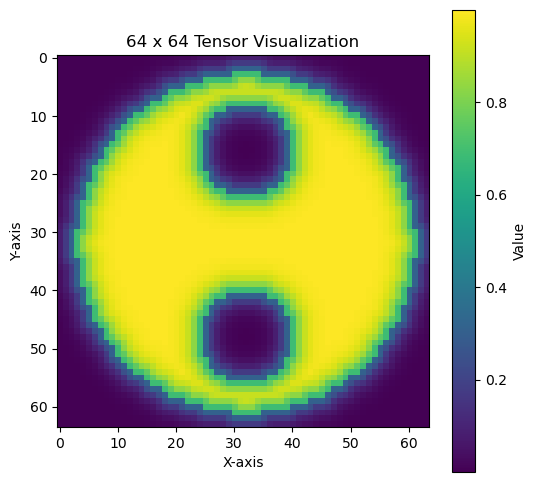

In [161]:
# Create the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(chi_train[19], cmap='viridis')
plt.colorbar(label="Value")
plt.title("64 x 64 Tensor Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [275]:
import matplotlib.pyplot as plt

# Define a function for visualization
def visualize_results(model, test_loader, y_normalizer, num_samples=5):
    """
    Visualize model predictions against true values.

    Args:
        model: Trained model.
        test_loader: DataLoader for test data.
        y_normalizer: Normalizer for output data.
        num_samples: Number of samples to visualize.
    """
    model.eval()
    samples = 0
    
    mean_abs_rel_errors = []

    with torch.no_grad():
        for mm, chi, xx, yy in test_loader:
            if samples >= num_samples:
                break

            # Move data to device
            mm, chi, xx, yy = (
                mm.to(device).float(),
                chi.to(device).float(),
                xx.to(device).float(),
                yy.to(device).float(),
            )

            # Get model predictions
            out = model(xx, chi)
            out = y_normalizer.decode(out) * mm

            # Convert to CPU for visualization
            out_np = out[0].cpu().numpy().squeeze()  # Predicted
            yy_np = yy[0].cpu().numpy().squeeze()   # Ground truth

            # Plot true vs predicted
            plt.figure(figsize=(18, 6))

            plt.subplot(1, 3, 1)
            plt.title("Ground Truth")
            plt.imshow(yy_np, cmap="viridis", extent=(0, yy_np.shape[1], 0, yy_np.shape[0]))
            plt.colorbar(label="Value")

            plt.subplot(1, 3, 2)
            plt.title("Prediction")
            plt.imshow(out_np, cmap="viridis", extent=(0, out_np.shape[1], 0, out_np.shape[0]))
            plt.colorbar(label="Value")
            
            
            rel_error = abs((out_np-yy_np)/yy_np)
            
            plt.subplot(1, 3, 3)
            plt.title("rel. error")
            plt.imshow(rel_error, cmap="viridis", extent=(0, out_np.shape[1], 0, out_np.shape[0]))
            plt.colorbar(label="Value")
            
            print(np.mean(rel_error[~np.isnan(rel_error)]))

            plt.tight_layout()
            plt.show()
            samples += 1
        

C:\Users\prane\AppData\Local\Temp\ipykernel_11836\3713926329.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_filename))
C:\Users\p

0.08455367


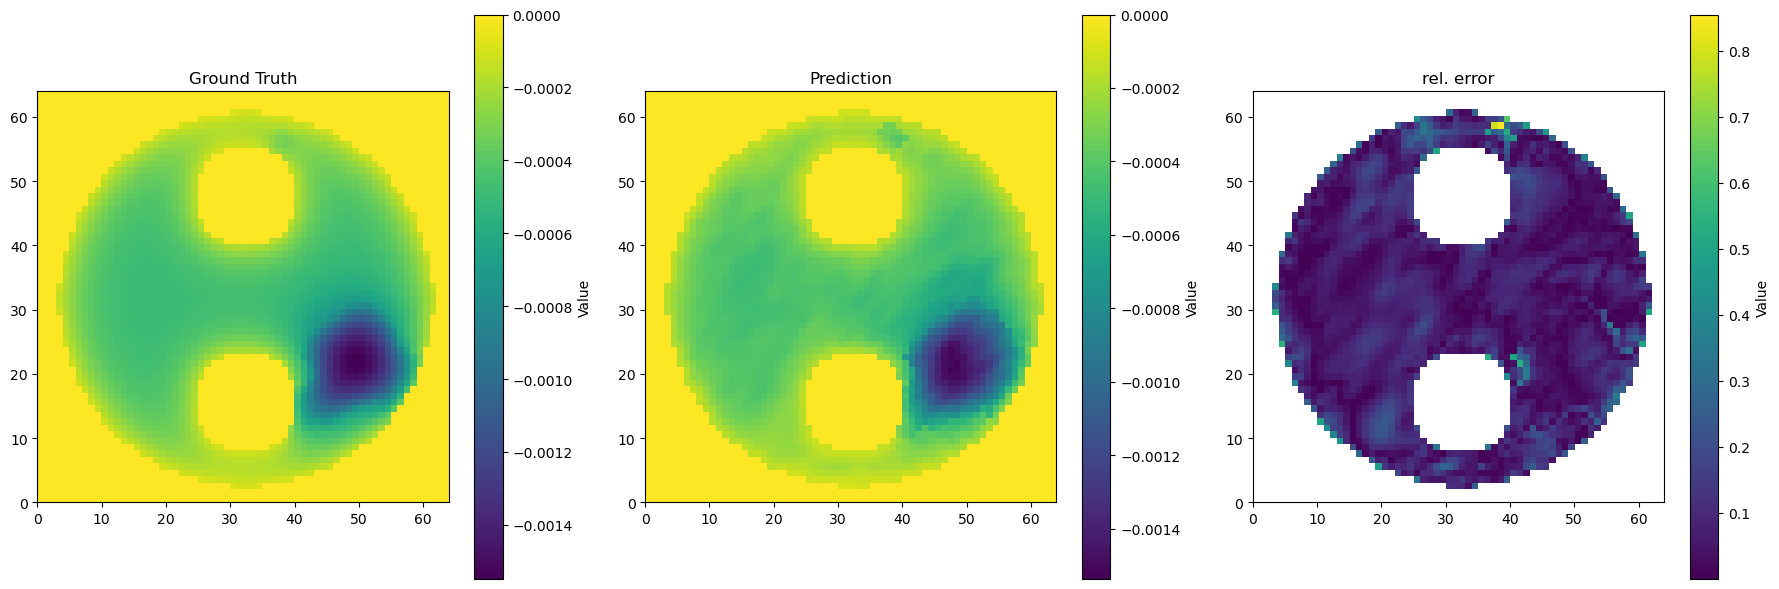

0.099993646


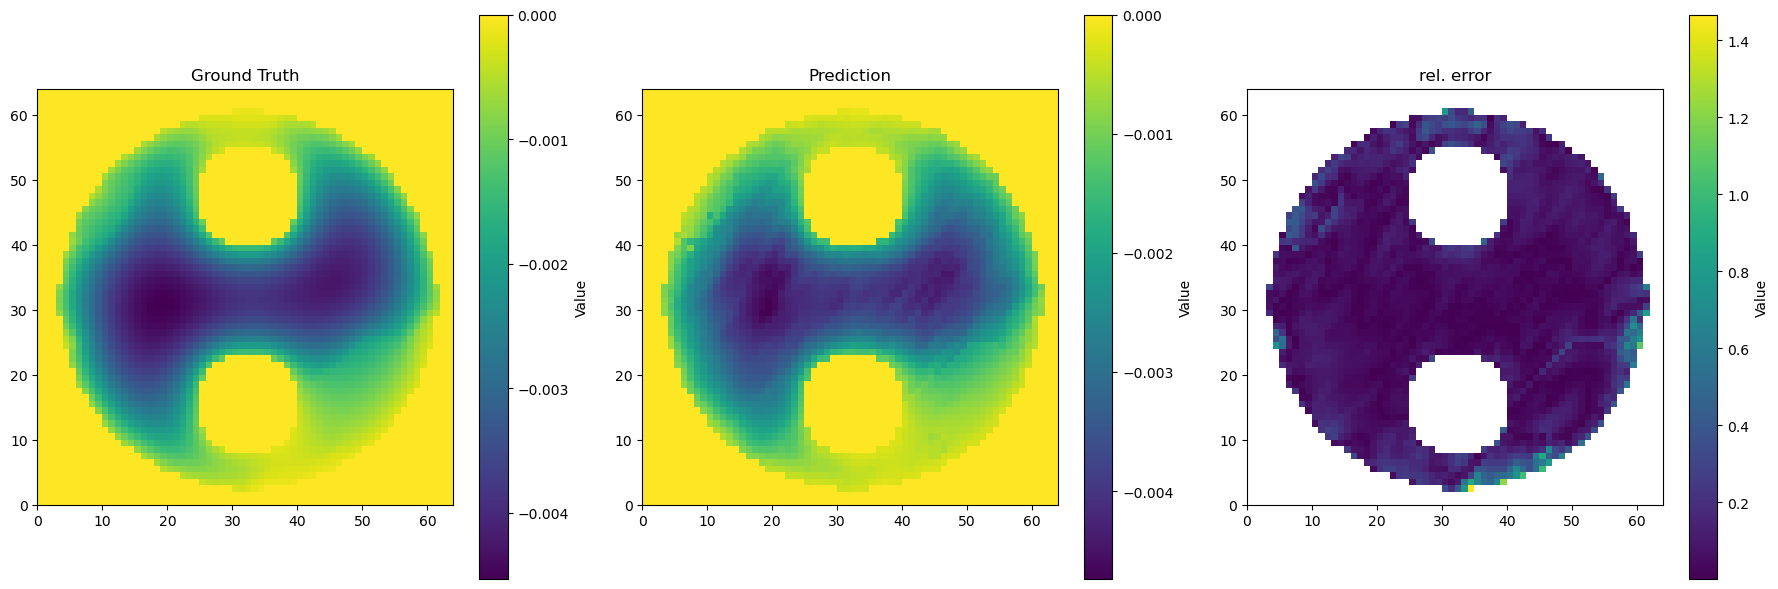

0.016983176


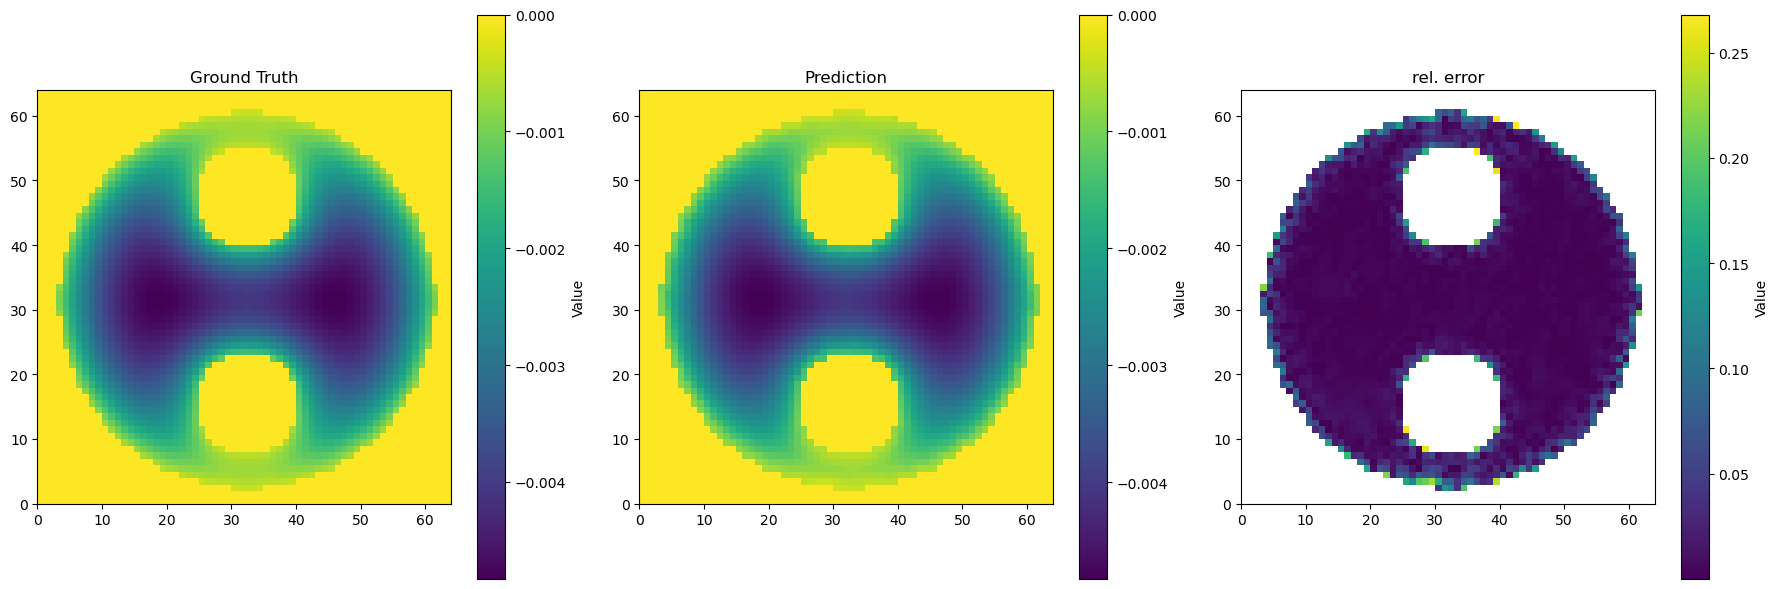

0.11241773


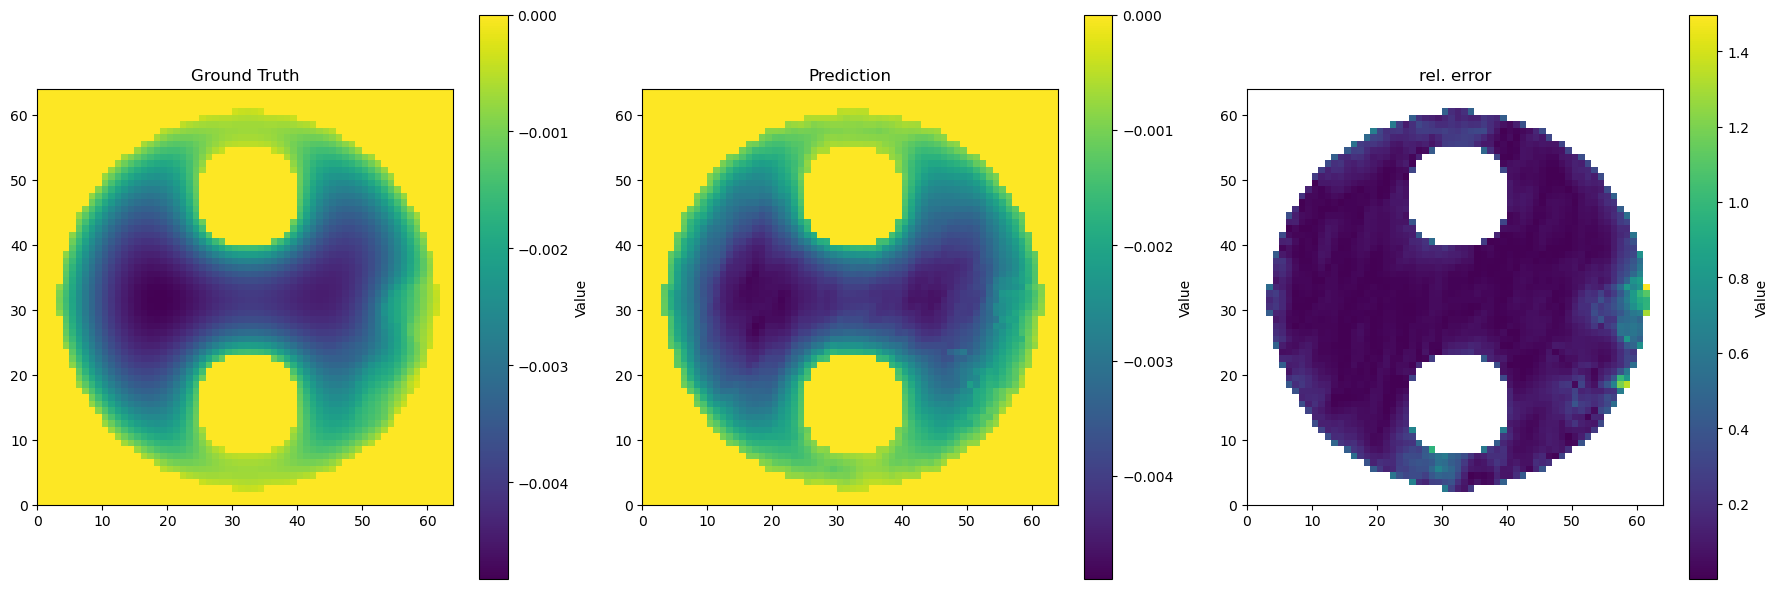

0.10330729


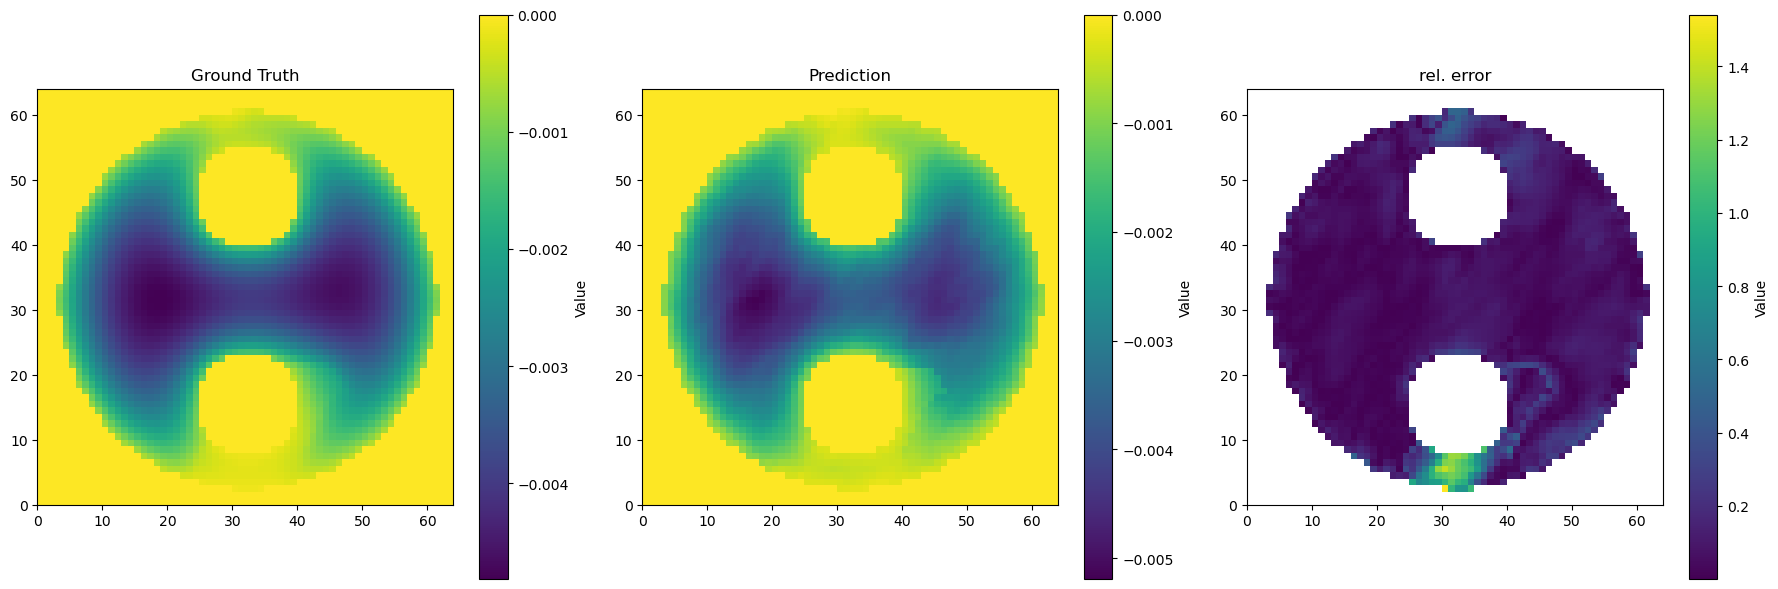

0.37495342


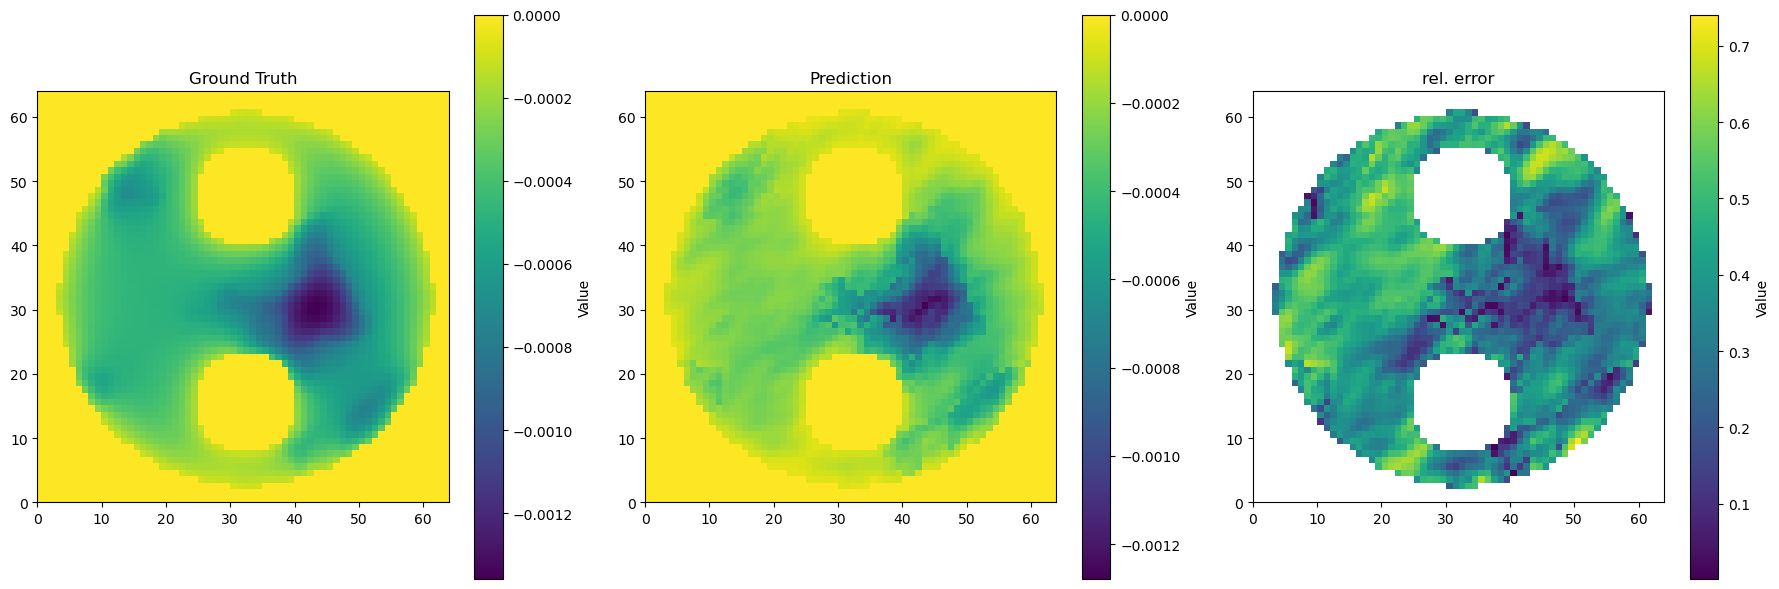

0.16862862


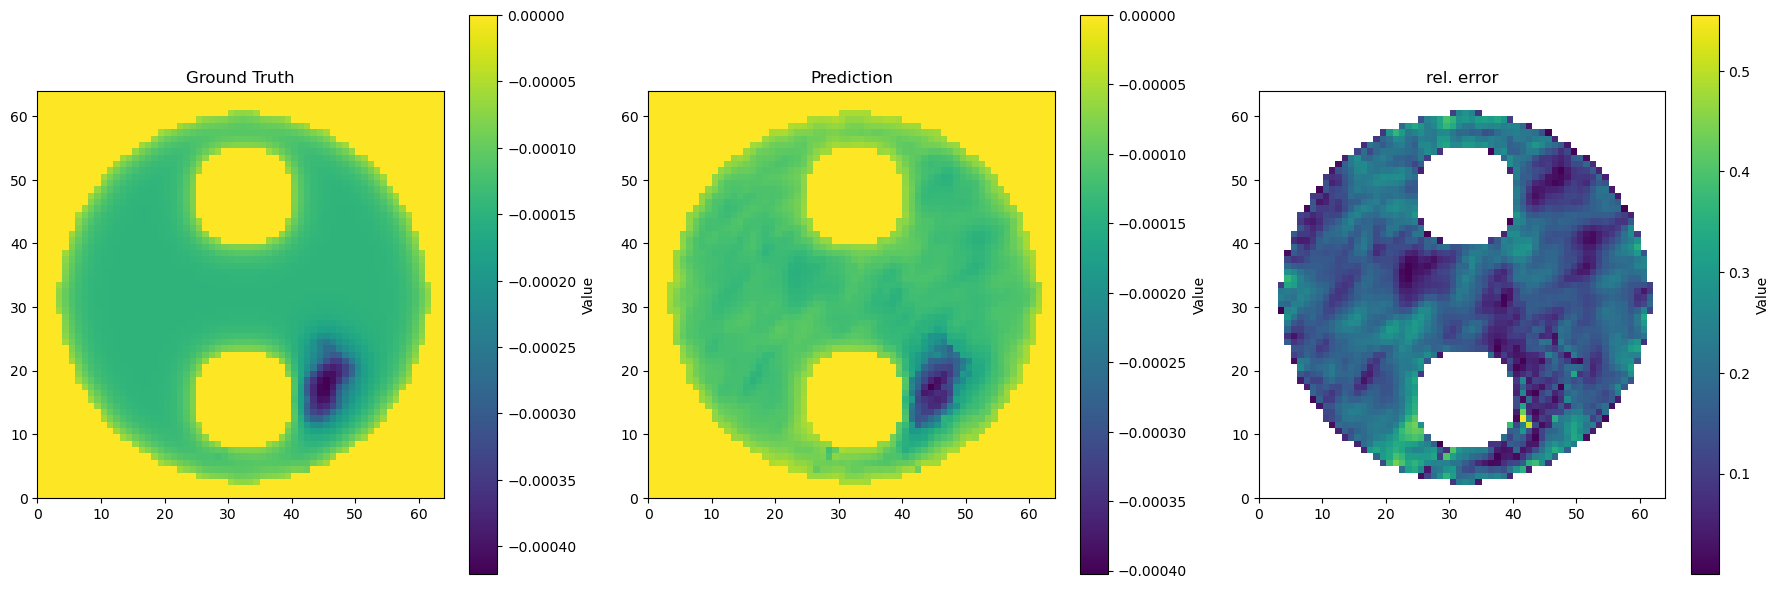

0.2613784


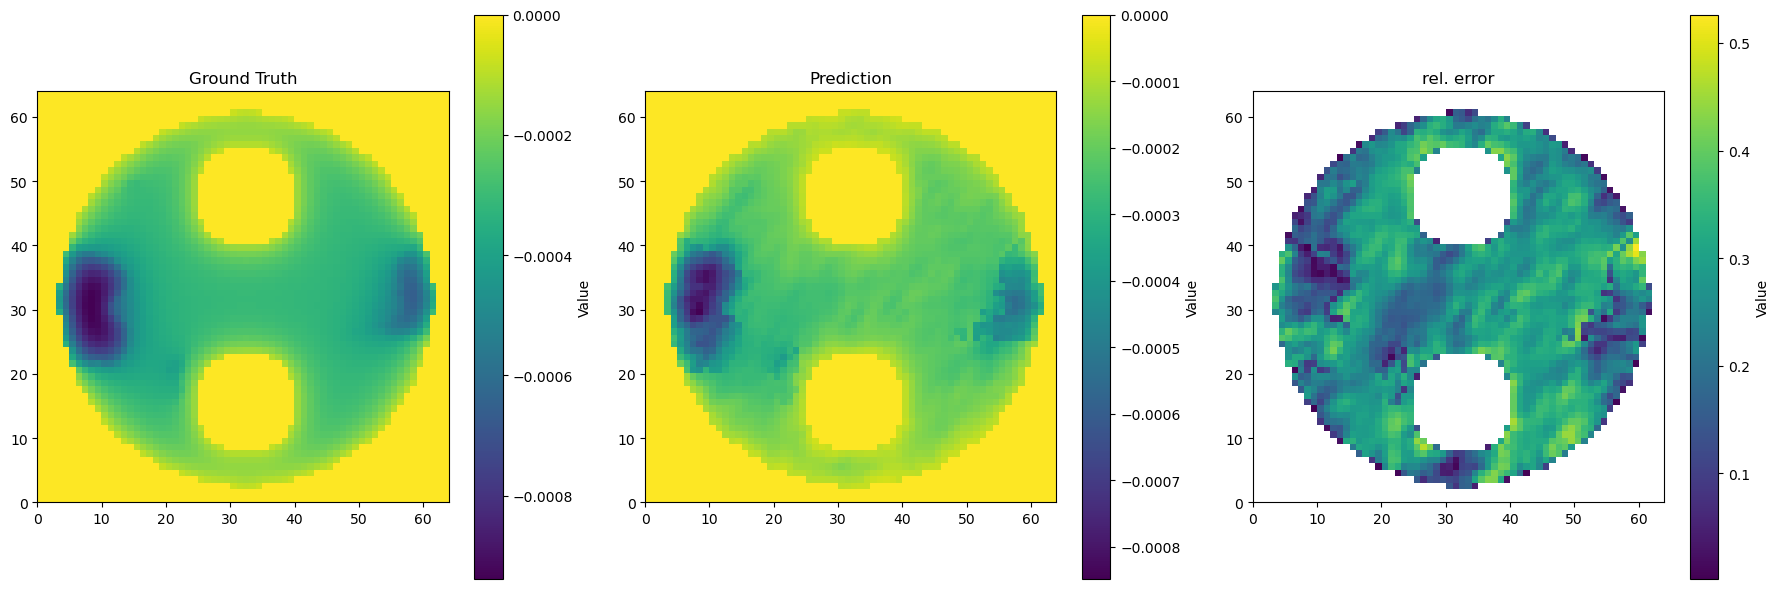

0.14090657


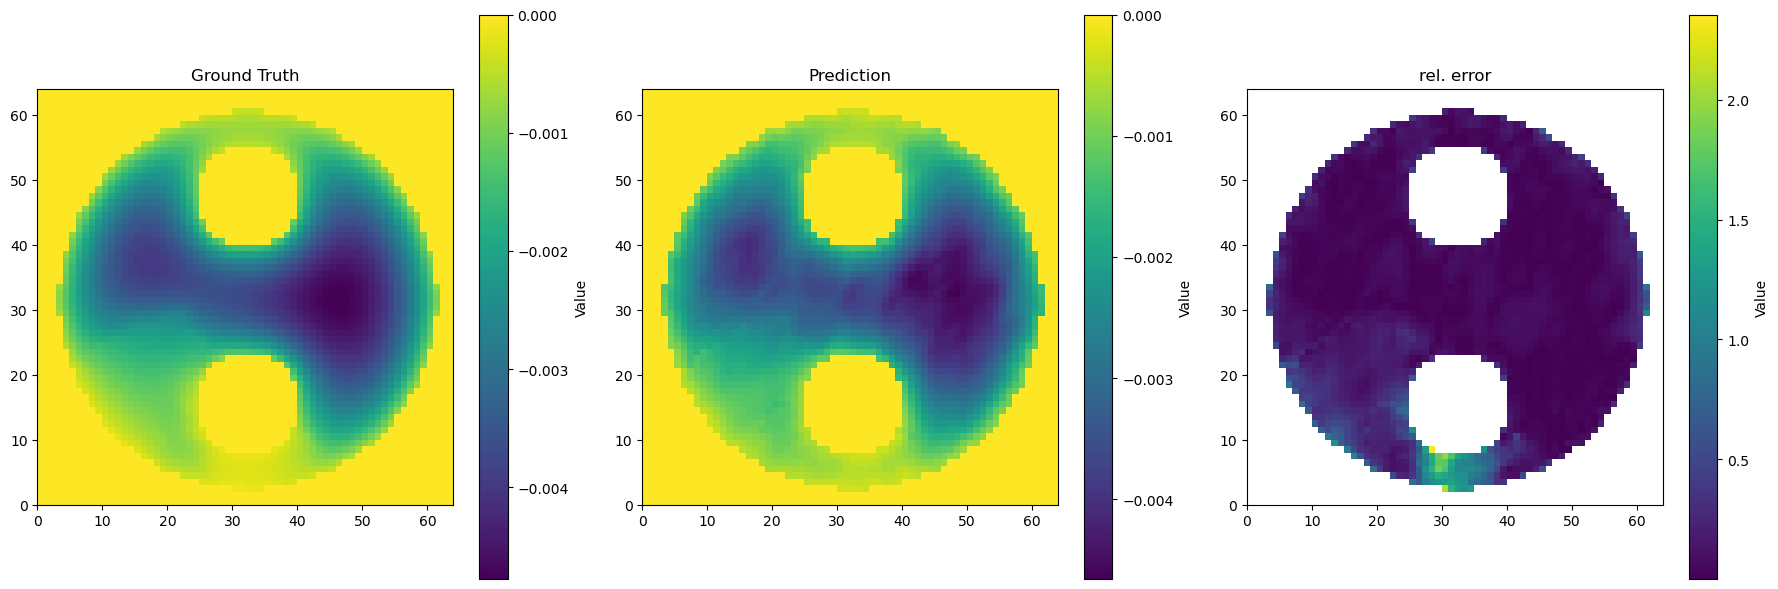

0.016983176


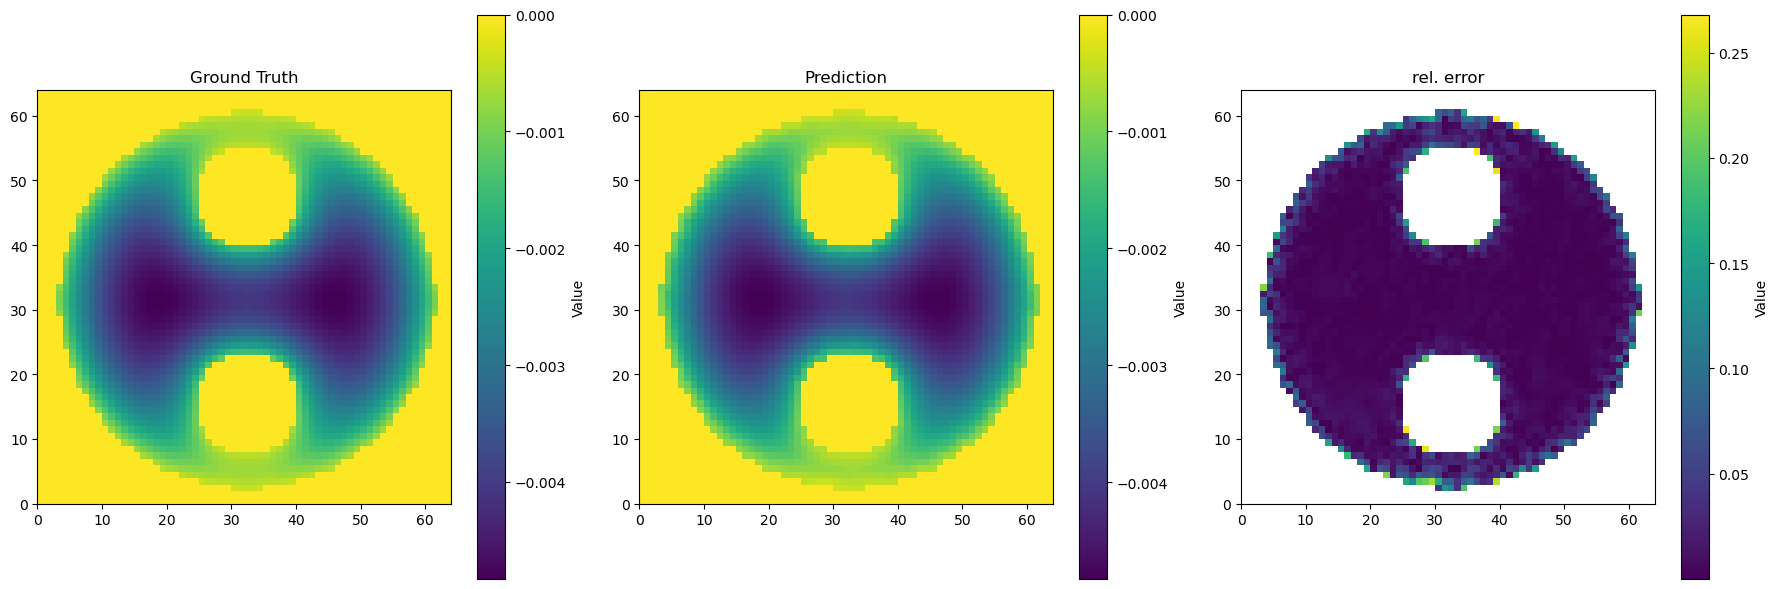

In [276]:
model = eDAFNO2d(modes, modes, width, nlayers).to(device)
model.load_state_dict(torch.load(model_filename))


visualize_results(model, test_loader, y_normalizer, num_samples=200)


In [19]:
def compute_average_relative_error_per_grid(model, test_loader, y_normalizer):
    """
    Compute the average relative error for each grid, considering only non-NaN values,
    and then take the overall average across all grids.

    Args:
        model: Trained model.
        test_loader: DataLoader for test data.
        y_normalizer: Normalizer for output data.

    Returns:
        overall_average_error: Mean of average relative errors across all grids.
    """
    model.eval()  # Set model to evaluation mode
    grid_average_errors = []
    grid_average_abs_errors = []

    with torch.no_grad():
        for mm, chi, xx, yy in test_loader:
            # Move data to the appropriate device
            mm, chi, xx, yy = (
                mm.to(device).float(),
                chi.to(device).float(),
                xx.to(device).float(),
                yy.to(device).float(),
            )

            # Get model predictions
            out = model(xx, chi)
            out = y_normalizer.decode(out) * mm

            # Compute the relative error for each grid
            relative_error = torch.abs((yy - out)/ yy)
            
            abs_error = torch.abs(yy-out)

            # Replace NaNs in relative error with a mask
            relative_error = relative_error.cpu().numpy()
            abs_error = abs_error.cpu().numpy()
            valid_mask = ~np.isnan(relative_error)  # Boolean mask of valid (non-NaN) values

            # Compute average relative error for each grid, considering only valid entries
            for i in range(relative_error.shape[0]):  # Iterate over each grid in the batch
                grid_errors = relative_error[i][valid_mask[i]]  # Filter valid errors for the grid
                grid_abs_errors = abs_error[i][valid_mask[i]]
                if len(grid_errors) > 0:
                    grid_average_errors.append(np.median(grid_errors))
                else:
                    grid_average_errors.append(0.0)  # Handle case where all values are NaN
                    
                if len(grid_abs_errors) > 0:
                    grid_average_abs_errors.append(np.mean(grid_abs_errors))
                else:
                    grid_average_abs_errors.append(0.0)  # Handle case where all values are NaN

    # Overall average error across all grids
    overall_average_error = np.mean(grid_average_errors)
    overall_average_abs_error = np.mean(grid_average_abs_errors)
    print(f"Overall Average Relative Error: {overall_average_error:.5f}, abs: {overall_average_abs_error}")
    return overall_average_error, overall_average_abs_error


In [20]:
mean_relative_error, mean_abs_error = compute_average_relative_error_per_grid(model, test_loader, y_normalizer)
print(mean_relative_error)
print(mean_abs_error)

Overall Average Relative Error: 0.13744, abs: 8.092720236163586e-05
0.13743892
8.09272e-05


In [21]:
error_dist

NameError: name 'error_dist' is not defined

In [22]:
# we can now take a model trained on 1 geometry and apply it to another 
import pickle

rel_error_shapes = ['triangle', 'bean', 'torus1' ,'torus2']
base_dir = './eDAFNO_2d/'
Ntotal = 1200
ntrain = 1000
ntest = 200

batch_size = 20

epochs = 15
scheduler_step = 100
tol_early_stop = 500

modes = 16
width = 32
nlayers = 4

scheduler_gamma = 0.5
wd = 1e-5
smooth_coef = 0.4

# experiments to be replicated with different seeds
seed = 0

shape_shape_errors = np.zeros((len(rel_error_shapes), len(rel_error_shapes)))

for i, shape_train in enumerate(rel_error_shapes):
    for j, shape_test in enumerate(rel_error_shapes):
        
        print(f'TRAIN on {shape_train}; TEST on {shape_test}')

        # LOAD MODEL

        model_filename = f'%s/DAFNOmodel_{shape_train}.ckpt' % base_dir

        model = eDAFNO2d(modes, modes, width, nlayers).to(device)
        model.load_state_dict(torch.load(model_filename))

        ## LOAD TEST DATA
        with open(f'../datasets_generated/dataset_for_DAFNO/DAFNOdataset_{shape_test}.pkl', 'rb') as file:
                generated_dataset = pickle.load(file)

        a_grids, u_grids, mask = generated_dataset


        sub = 1
        Sx = int(((64 - 1) / sub) + 1)
        Sy = Sx

        dist_in = calculate_positive_distance_to_boundary(mask)
        mask = torch.tensor(mask).repeat(Ntotal, 1, 1)

        dist_in = torch.tensor(dist_in, dtype=torch.float).repeat(Ntotal, 1, 1)


        smooth_chi_input = smooth_chi(mask, dist_in, smooth_coef)

        input_functions = torch.tensor(a_grids, dtype=torch.float)
        output = torch.tensor(u_grids, dtype=torch.float)


        mask_train = mask[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
        mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

        mask_train = mask_train.reshape(ntrain, Sx, Sy, 1)
        mask_test = mask_test.reshape(ntest, Sx, Sy, 1)

        chi_train = smooth_chi_input[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
        chi_test = smooth_chi_input[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

        chi_train = chi_train.reshape(ntrain, Sx, Sy, 1)
        chi_test = chi_test.reshape(ntest, Sx, Sy, 1)

        x_train = input_functions[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
        x_test = input_functions[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

        y_train = output[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
        y_test = output[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

        # Normalizers
        y_normalizer = GaussianNormalizer(y_train)
        y_train = y_normalizer.encode(y_train)


        # reshape
        y_train = y_train.reshape(ntrain, Sx, Sy, 1)
        y_test = y_test.reshape(ntest, Sx, Sy, 1)

        x_train = x_train.reshape(ntrain, Sx, Sy, 1)
        x_test = x_test.reshape(ntest, Sx, Sy, 1)


        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_train, chi_train, x_train, y_train),
                                               batch_size=batch_size,
                                               shuffle=False)
        test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, x_test, y_test),
                                              batch_size=batch_size,
                                              shuffle=False)


        mean_relative_error, abs_error = compute_average_relative_error_per_grid(model, test_loader, y_normalizer)
        
        shape_shape_errors[i,j] = mean_relative_error


TRAIN on triangle; TEST on triangle


C:\Users\prane\AppData\Local\Temp\ipykernel_15424\2867227039.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_filename))
C:\Users\

Overall Average Relative Error: 0.14190, abs: 0.00014662492321804166
TRAIN on triangle; TEST on bean
Overall Average Relative Error: 7.48663, abs: 0.0005890715983696282
TRAIN on triangle; TEST on torus1
Overall Average Relative Error: 8.20270, abs: 0.0006101118633523583
TRAIN on triangle; TEST on torus2
Overall Average Relative Error: 15.76508, abs: 0.000773798965383321
TRAIN on bean; TEST on triangle
Overall Average Relative Error: 3.69314, abs: 0.0006597887258976698
TRAIN on bean; TEST on bean
Overall Average Relative Error: 0.09247, abs: 6.929509982001036e-05
TRAIN on bean; TEST on torus1
Overall Average Relative Error: 6.31458, abs: 0.0003902109747286886
TRAIN on bean; TEST on torus2
Overall Average Relative Error: 6.52167, abs: 0.0004004082875326276
TRAIN on torus1; TEST on triangle
Overall Average Relative Error: 9.54142, abs: 0.0005674663698300719
TRAIN on torus1; TEST on bean
Overall Average Relative Error: 6.37872, abs: 0.0005153304082341492
TRAIN on torus1; TEST on torus1
Ove

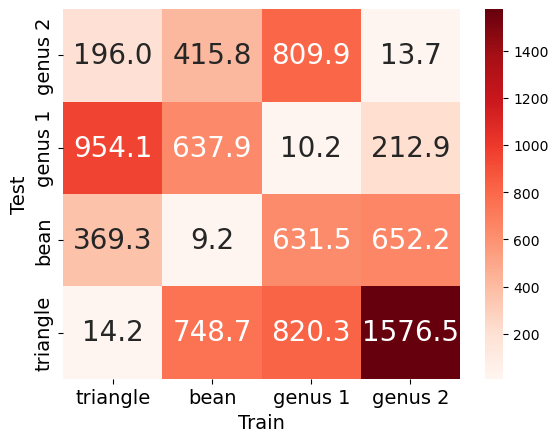

In [25]:
import seaborn as sns

axis_labels = ['triangle', 'bean', 'genus 1' ,'genus 2']


fig, ax = plt.subplots()
sns.heatmap(100*shape_shape_errors, annot=True, fmt=".1f", cmap="Reds", ax=ax,  xticklabels=axis_labels, yticklabels=axis_labels, annot_kws={"fontsize": 20})

# Flip the y-axis
ax.invert_yaxis()

ax.set_xticklabels(axis_labels, fontsize=14)
ax.set_yticklabels(axis_labels, fontsize=14)


# Add labels
ax.set_xlabel("Train", fontsize=14)
ax.set_ylabel("Test", fontsize=14)
plt.show()

C:\Users\prane\AppData\Local\Temp\ipykernel_11836\3617710534.py:55: RuntimeWarning: invalid value encountered in divide
  plt.imshow(abs((out_np-yy_np)/yy_np), cmap="viridis", extent=(0, out_np.shape[1], 0, out_np.shape[0]))


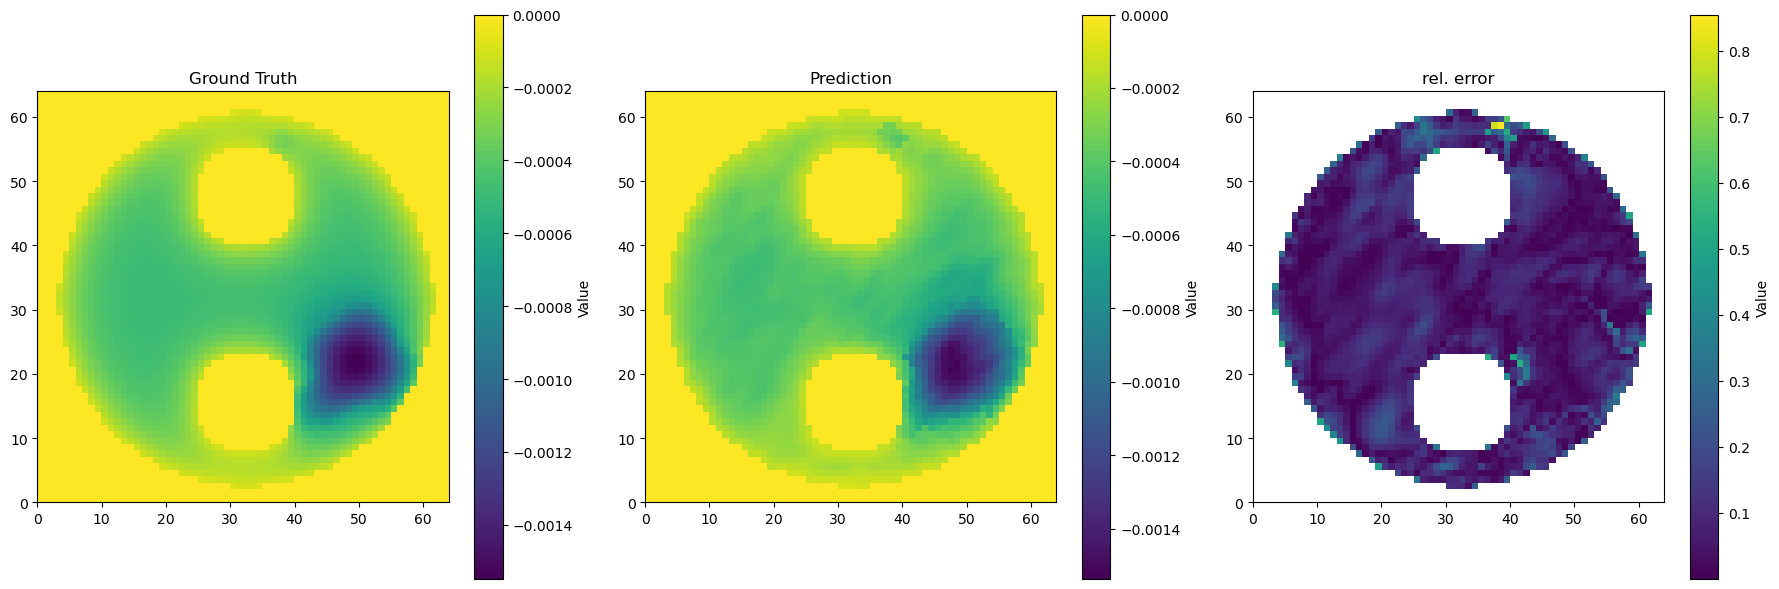

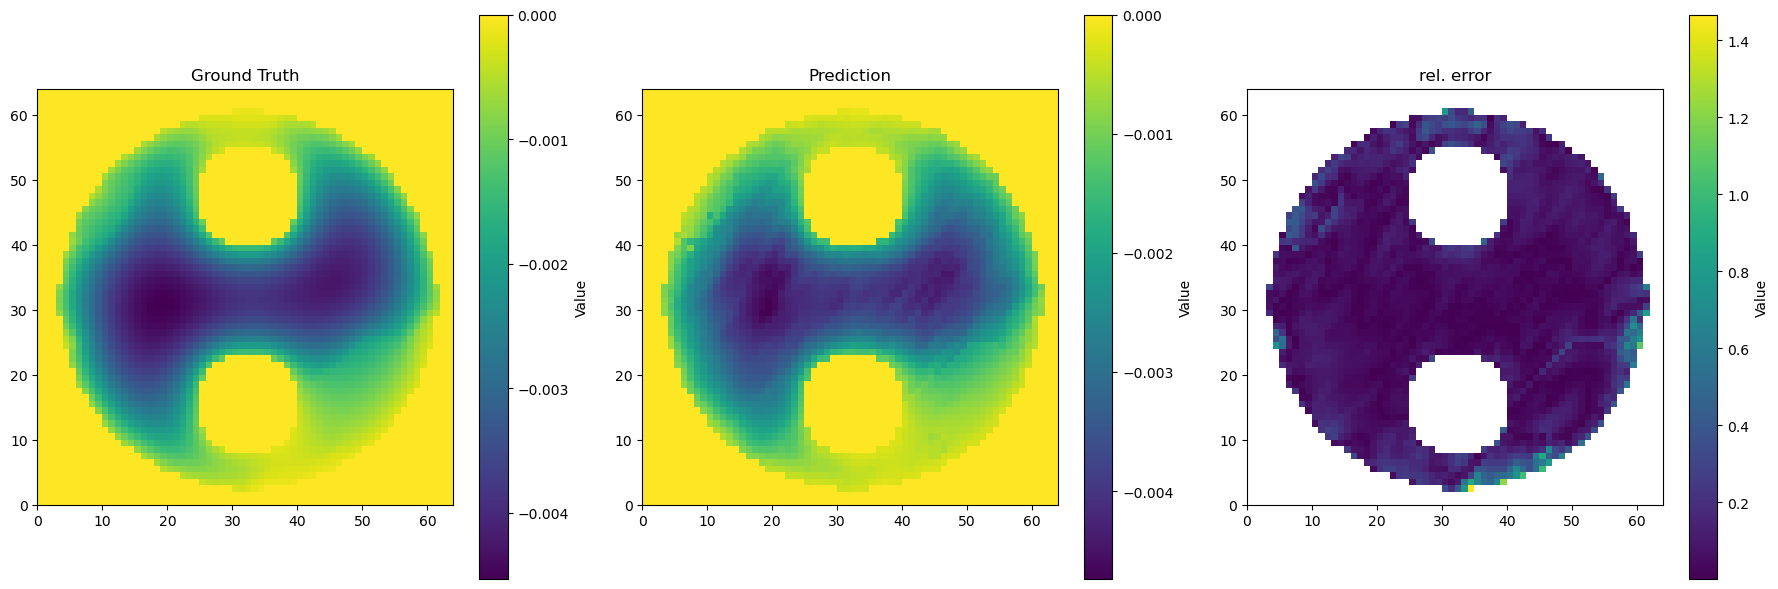

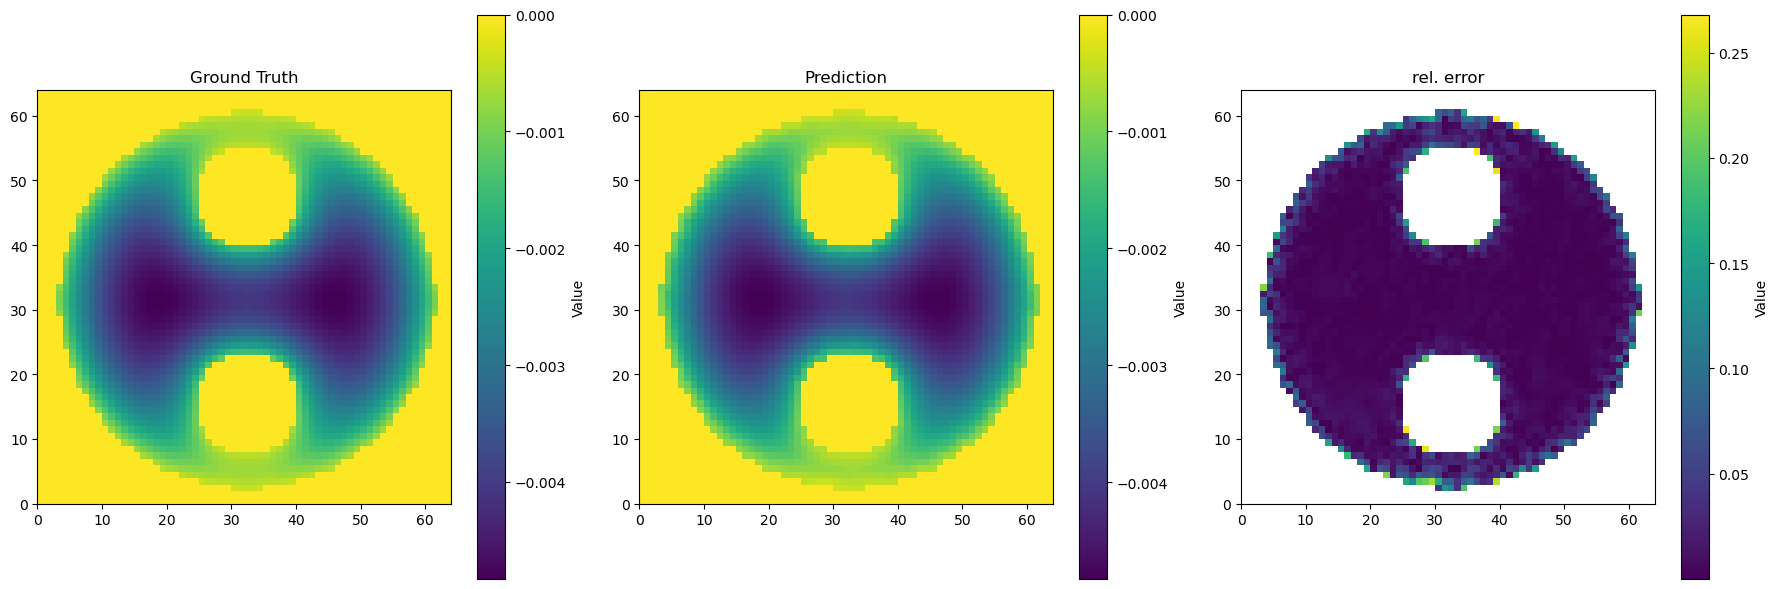

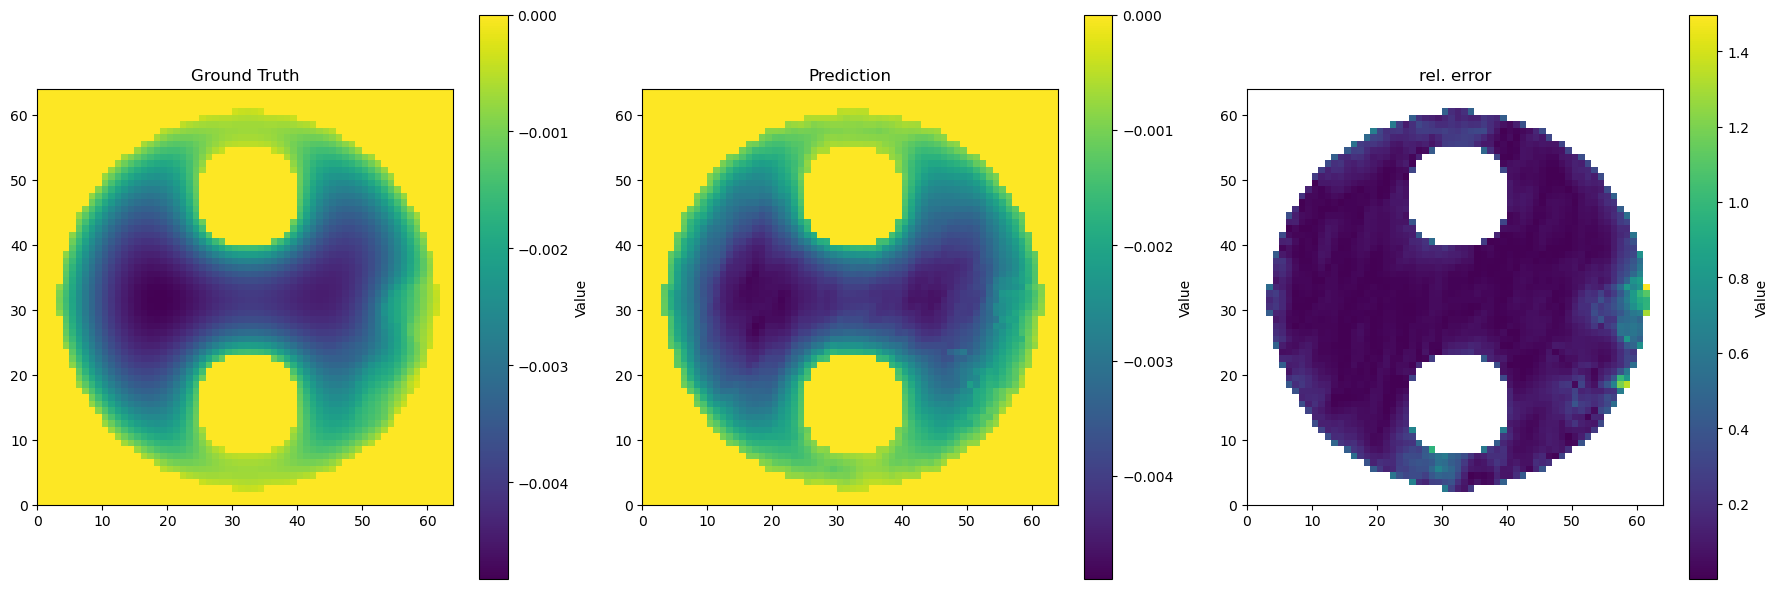

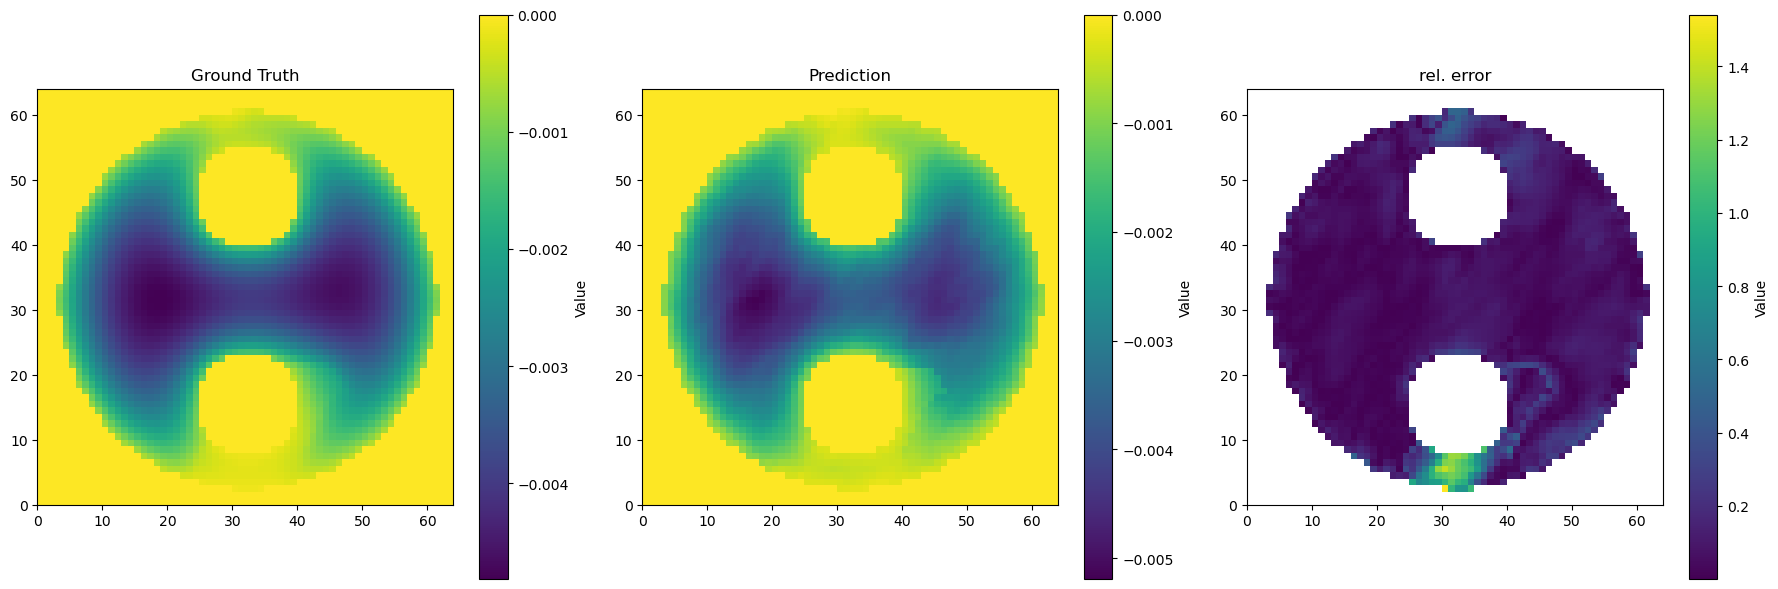

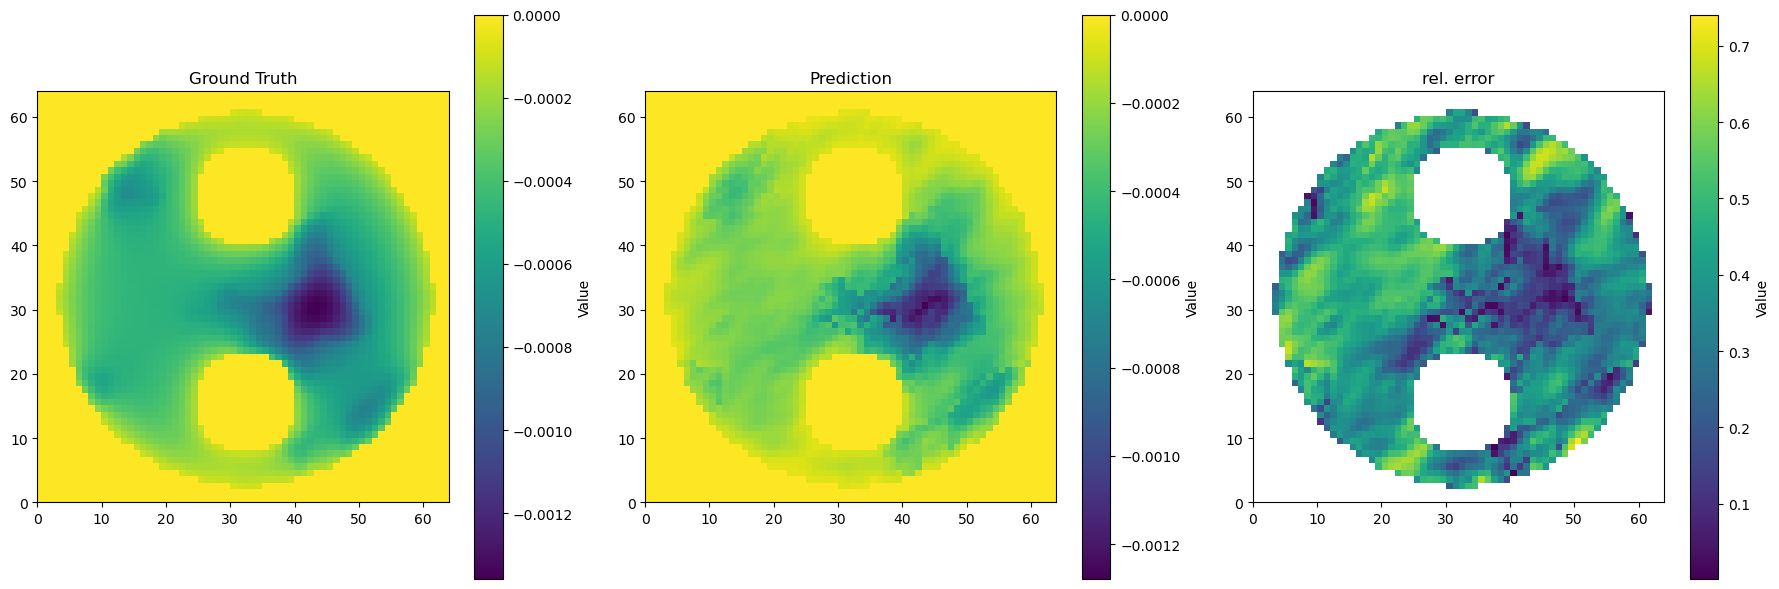

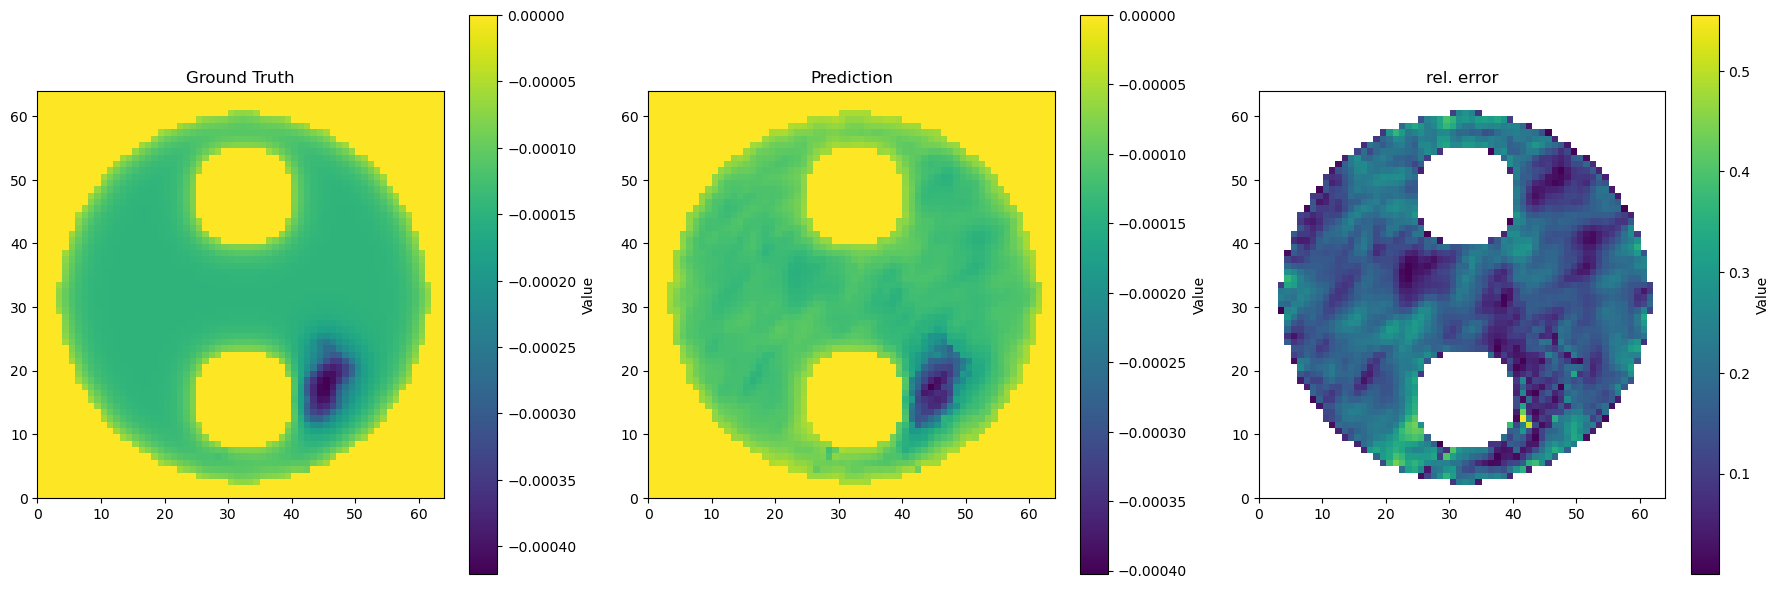

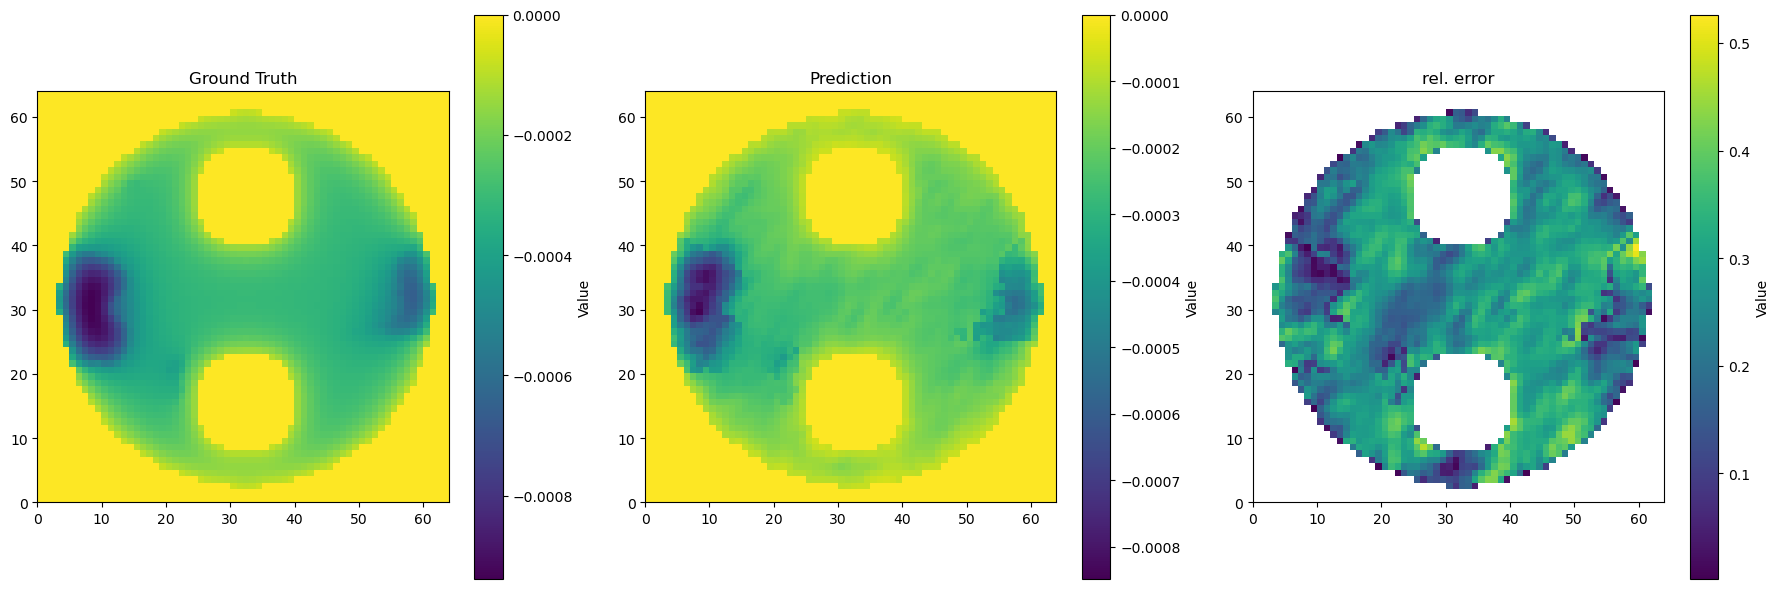

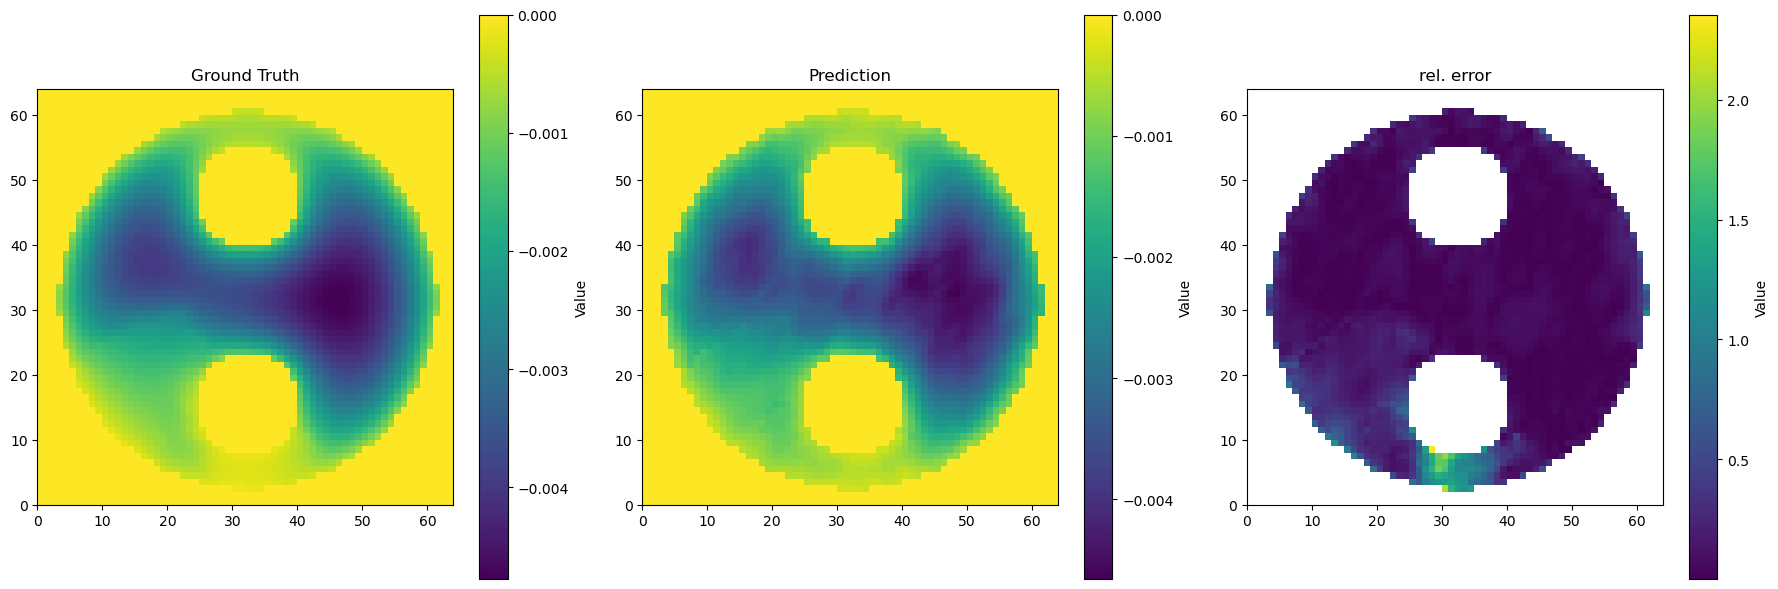

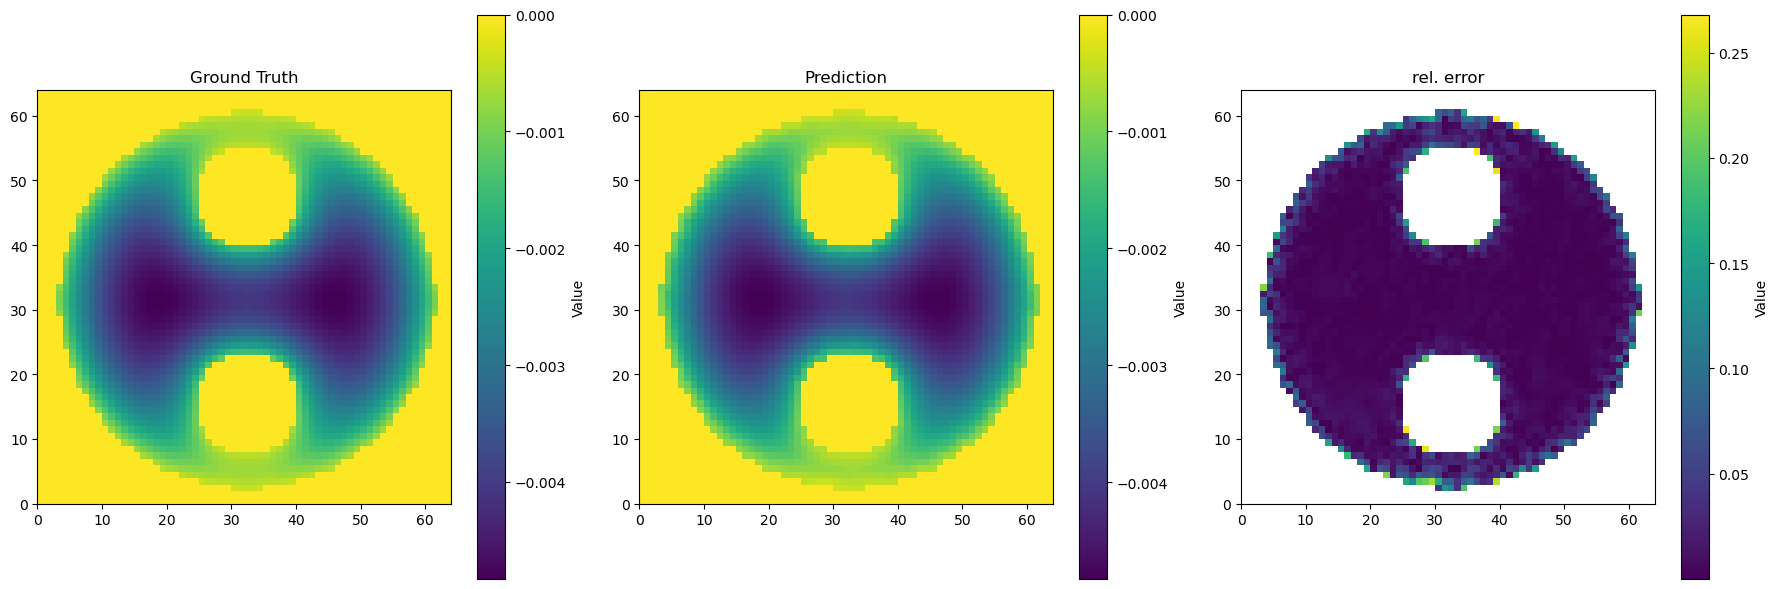

In [262]:
visualize_results(model, test_loader, y_normalizer, num_samples=50)